# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of fruit production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 
 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fruits = pd.read_csv('./Italy_crop_data/italy_fruits.csv',skipinitialspace=True)
fruits.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2020,2020,33,NaN,NaN
1,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2021,2021,35,NaN,NaN
2,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2022,2022,37,NaN,NaN
3,ITE45,Frosinone,ART,total area - hectares,POMETES,pomegranates,2020,2020,11,NaN,NaN
4,ITE45,Frosinone,ART,total area - hectares,POMETES,pomegranates,2021,2021,12,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
fruits = fruits.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
fruits

,Territory,Data type,Type of crop,Select time,Value
0,Venezia,production area - hectares,kiwi,2020,33
1,Venezia,production area - hectares,kiwi,2021,35
2,Venezia,production area - hectares,kiwi,2022,37
3,Frosinone,total area - hectares,pomegranates,2020,11
4,Frosinone,total area - hectares,pomegranates,2021,12
...,...,...,...,...,...
23818,Treviso,total area - hectares,sour cherries,2022,15
23819,Padova,total area - hectares,sour cherries,2022,12
23820,Rovigo,total area - hectares,sour cherries,2022,1
23821,Pesaro e Urbino,total area - hectares,sour cherries,2022,3


In [4]:
# Rename Columns
fruits = fruits.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(fruits):
    print('DATASET SHAPE: ', fruits.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fruits.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fruits.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fruits.isnull().sum())
show_info(fruits)

DATASET SHAPE:  (23823, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23823 entries, 0 to 23822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       23823 non-null  object
 1   Data_type  23823 non-null  object
 2   Type_crop  23823 non-null  object
 3   Year       23823 non-null  int64 
 4   Value      23823 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 930.7+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          107
Data_type       4
Type_crop      58
Year            3
Value        3119
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing fruits

In [6]:
#fruits.City.unique()


In [7]:
fruits.Data_type.unique()

array(['production area - hectares ', 'total area - hectares',
       'harvested production - quintals ', 'total production - quintals '],
      dtype=object)

## Select only Values for total fruits production - quintals


In [8]:
fruits_total_prod = fruits[fruits['Data_type'] == 'total production - quintals ']
fruits_total_prod.head()

,City,Data_type,Type_crop,Year,Value
23,Perugia,total production - quintals,nectarine,2020,2000
24,Perugia,total production - quintals,nectarine,2021,2000
25,Perugia,total production - quintals,nectarine,2022,600
28,Lucca,total production - quintals,plum,2020,2090
29,Lucca,total production - quintals,plum,2021,2100


In [9]:
fruits_total_prod = fruits_total_prod.rename(columns = {'Value':'Total_production'})
fruits_total_prod

,City,Data_type,Type_crop,Year,Total_production
23,Perugia,total production - quintals,nectarine,2020,2000
24,Perugia,total production - quintals,nectarine,2021,2000
25,Perugia,total production - quintals,nectarine,2022,600
28,Lucca,total production - quintals,plum,2020,2090
29,Lucca,total production - quintals,plum,2021,2100
...,...,...,...,...,...
23783,Nuoro,total production - quintals,citrus fruit,2021,45070
23787,Cagliari,total production - quintals,citrus fruit,2021,5721
23791,Oristano,total production - quintals,citrus fruit,2021,114990
23795,Barletta-Andria-Trani,total production - quintals,citrus fruit,2021,3050


In [10]:
fruits_total_prod =fruits_total_prod.drop(columns =['Data_type'])
fruits_total_prod

,City,Type_crop,Year,Total_production
23,Perugia,nectarine,2020,2000
24,Perugia,nectarine,2021,2000
25,Perugia,nectarine,2022,600
28,Lucca,plum,2020,2090
29,Lucca,plum,2021,2100
...,...,...,...,...
23783,Nuoro,citrus fruit,2021,45070
23787,Cagliari,citrus fruit,2021,5721
23791,Oristano,citrus fruit,2021,114990
23795,Barletta-Andria-Trani,citrus fruit,2021,3050


## Total fruit production in 2020-2022

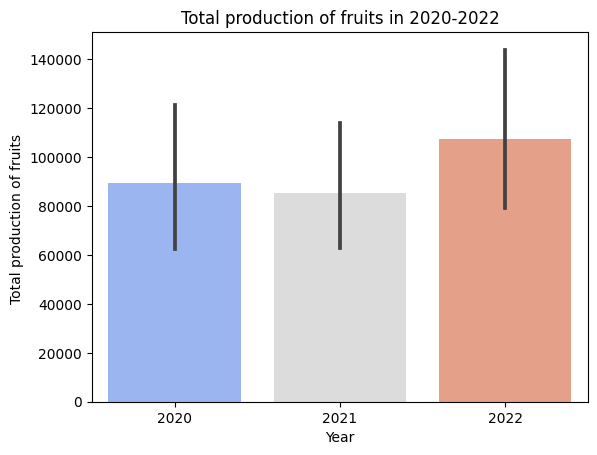

In [11]:

sns.barplot(x= 'Year', y= 'Total_production',data = fruits_total_prod, palette='coolwarm')
plt.title('Total production of fruits in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of fruits ')
plt.show()



## Fruit production by Cities 

In [12]:
fruits_total_prod_region = fruits_total_prod.groupby(by = fruits_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
fruits_total_prod_region

,City,Total_production
94,Trentino Alto Adige / Südtirol,88342093
14,Bolzano / Bozen,56726194
21,Catania,48114864
86,Siracusa,36396160
95,Trento,31615899
25,Cosenza,25685561
76,Reggio di Calabria,23195041
20,Caserta,22776411
103,Verona,16895734
53,Messina,15592550


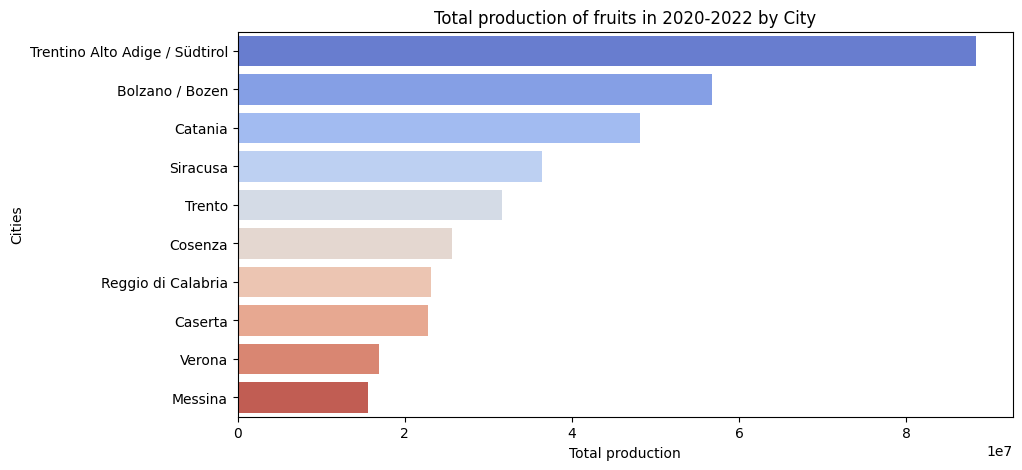

In [13]:
plt.figure(figsize= (10,5))
sns.barplot(x=fruits_total_prod_region['Total_production'],y= fruits_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total production of fruits in 2020-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## The  most produced fruits 2020-2022

In [14]:
#print(fruits_total_prod.Type_crop.max())
#print(fruits_total_prod.Type_crop.value_counts())
#print(fruits_total_prod.Type_crop.nunique())



Dataset shows there are 58 different types of fruits cultivated in Italy. The top most produced crops are White oranges, Peach, Pear, Apples, Apricot, Cherry, Plum, Kiwi, Nectarine, Lemon, Orange and Raspberry. 

In [15]:
fruits_total_prod.describe()

,Year,Total_production
count,5950.000000,5.950000e+03
mean,2020.960336,9.302331e+04
std,0.779921,6.434403e+05
min,2020.000000,0.000000e+00
25%,2020.000000,4.300000e+02
50%,2021.000000,2.775000e+03
75%,2022.000000,1.770000e+04
max,2022.000000,1.513440e+07


<AxesSubplot: >

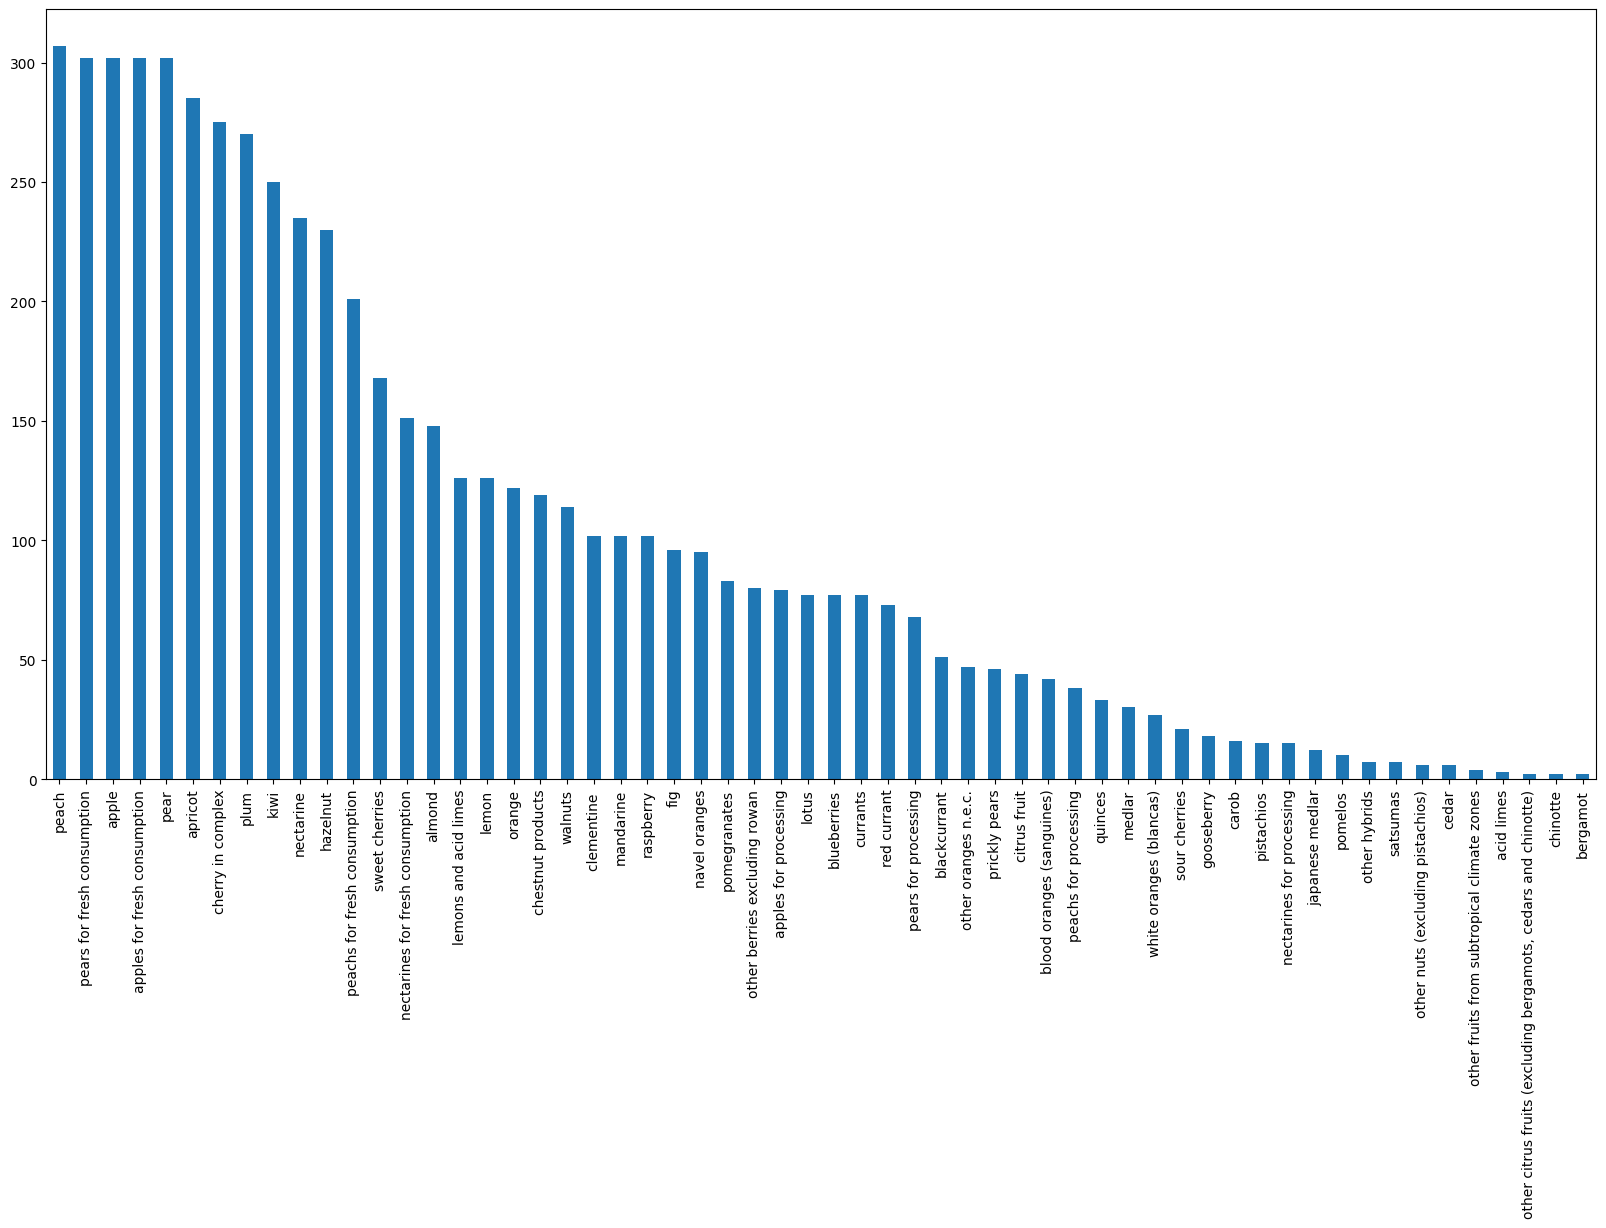

In [16]:
plt.figure(figsize=(20,10))
fruits_total_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [17]:
fruits_top10 = fruits_total_prod.apply(lambda row: row[fruits_total_prod['Type_crop'].isin(['peach', 'pear', 'apple', 'apricot', 'orange',
                                                                                           'plum', 'kiwi', 'lemon', 'cherry in complex','nectarine'])])

fruits_top10.head()

,City,Type_crop,Year,Total_production
23,Perugia,nectarine,2020,2000
24,Perugia,nectarine,2021,2000
25,Perugia,nectarine,2022,600
28,Lucca,plum,2020,2090
29,Lucca,plum,2021,2100


## Stats

In [18]:
fruits_top10.describe().astype(int)

,Year,Total_production
count,2474,2474
mean,2020,105694
std,0,700401
min,2020,0
25%,2020,900
50%,2021,4760
75%,2022,23075
max,2022,15134400


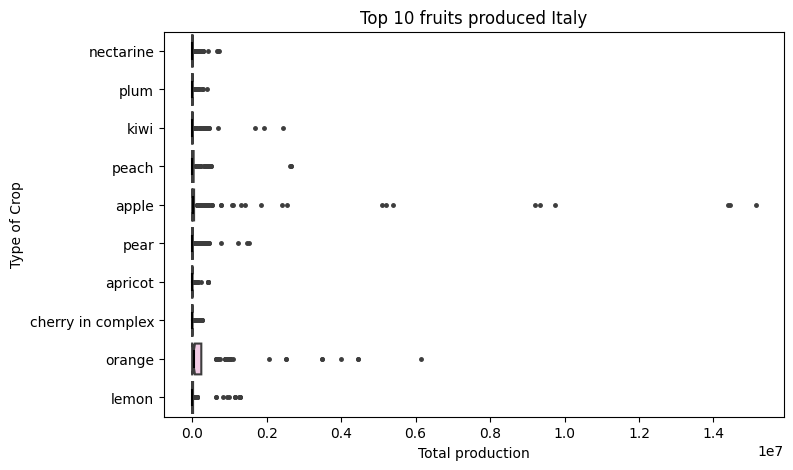

In [19]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=fruits_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 fruits produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

In [20]:
fruits_top10

,City,Type_crop,Year,Total_production
23,Perugia,nectarine,2020,2000
24,Perugia,nectarine,2021,2000
25,Perugia,nectarine,2022,600
28,Lucca,plum,2020,2090
29,Lucca,plum,2021,2100
...,...,...,...,...
14826,Bolzano / Bozen,kiwi,2021,1000
14827,Bolzano / Bozen,kiwi,2022,960
14837,Trento,kiwi,2020,11000
14838,Trento,kiwi,2021,10000


## Vizualization of ten type of fruits produced in Italy in the period of 2020-2022 

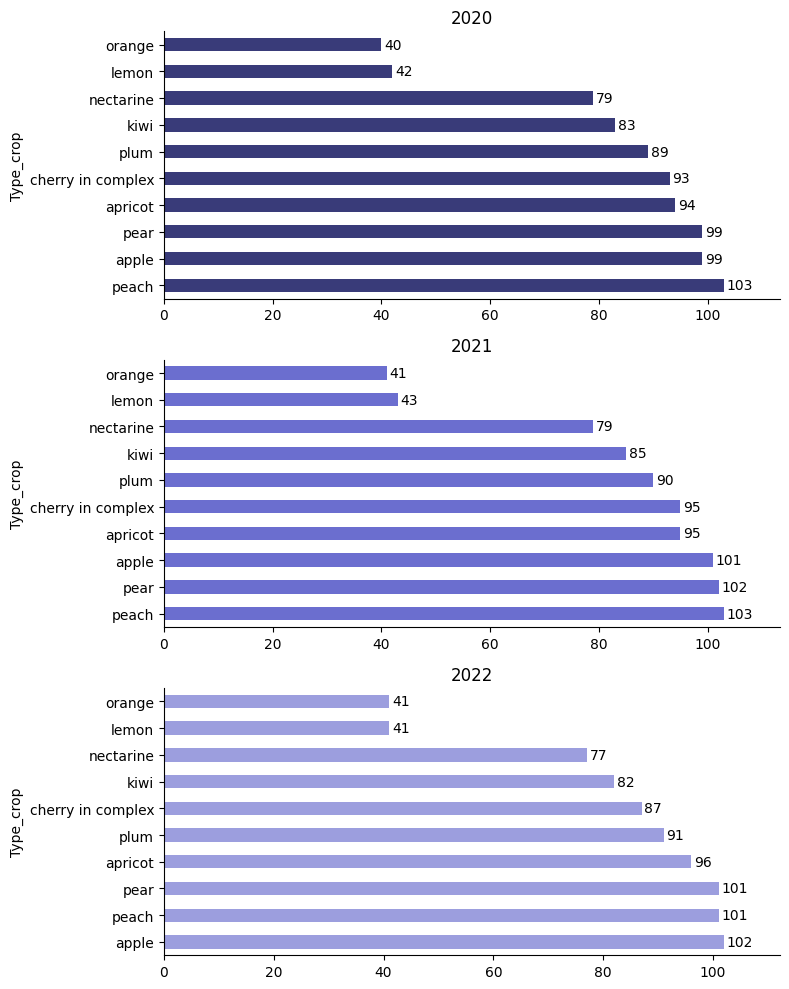

In [21]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = fruits_top10[fruits_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = fruits_top10[fruits_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = fruits_top10[fruits_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

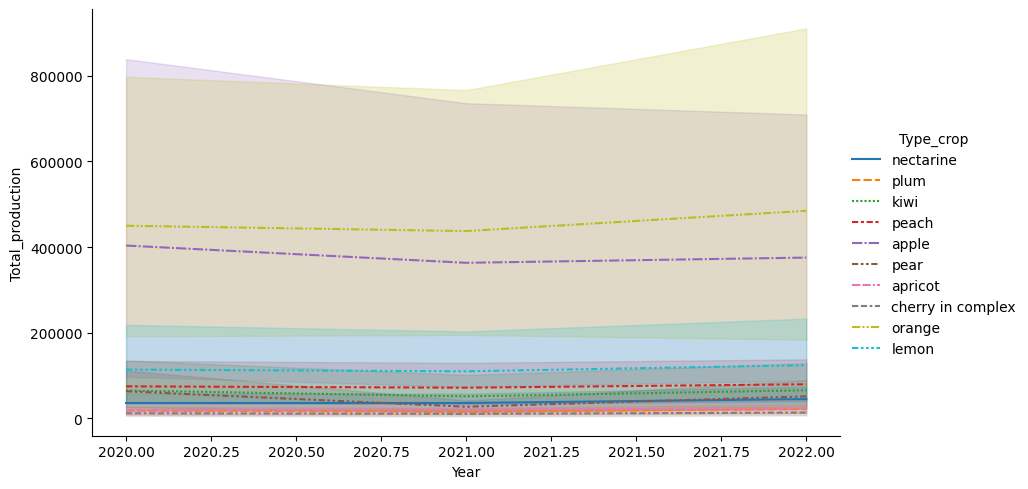

In [22]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=fruits_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [23]:
# Select year 2020 for future join with fertilizer
it_crop2020 = fruits_top10[fruits_top10['Year'] == 2020]
it_crop2020



,City,Type_crop,Year,Total_production
23,Perugia,nectarine,2020,2000
28,Lucca,plum,2020,2090
45,Lecce,kiwi,2020,1200
63,Modena,peach,2020,18900
69,Campobasso,kiwi,2020,3150
...,...,...,...,...
14789,Trento,cherry in complex,2020,21000
14801,Bolzano / Bozen,plum,2020,715
14813,Trento,plum,2020,2700
14825,Bolzano / Bozen,kiwi,2020,1000


#### Create new column for each selected crop produced 

In [24]:
# Create columns for each type of fertilizer 
it_crop2020_pivot = it_crop2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
it_crop2020_pivot

Total_production                                       \
Type_crop                     apple  apricot cherry in complex      kiwi   
City          Year                                                         
Agrigento     2020              NaN  57950.0            3830.0       NaN   
Alessandria   2020          24000.0   7600.0            3840.0     720.0   
Ancona        2020           5604.0    742.0             495.0     582.0   
Arezzo        2020         165000.0    840.0             720.0       NaN   
Ascoli Piceno 2020          13275.0  12112.0             379.0    4200.0   
...                             ...      ...               ...       ...   
Vercelli      2020           4700.0    390.0             680.0   71100.0   
Verona        2020        2408690.0   9145.0          111580.0  231850.0   
Vibo Valentia 2020           1960.0   1200.0            5000.0   14685.0   
Vicenza       2020          36750.0    425.0           17760.0    2930.0   
Viterbo       2020          20500.0   1980.0            7600.0   79000.0   

                                                                               
Type_crop             lemon nectarine     orange     peach      pear     plum  
City          Year                                                             
Agrigento     2020  19758.0   19798.0  1026000.0  480750.0       NaN   6095.0  
Alessandria   2020      NaN     120.0        NaN   41600.0   17430.0   4800.0  
Ancona        2020      NaN    2739.0        NaN    7137.0    1880.0   5523.0  
Arezzo        2020      NaN    3150.0        NaN   12000.0   52500.0  11700.0  
Ascoli Piceno 2020      NaN   24164.0        NaN   33034.0    4273.0  15528.0  
...                     ...       ...        ...       ...       ...      ...  
Vercelli      2020      NaN    1100.0        NaN   12000.0     520.0    980.0  
Verona        2020      NaN   69135.0        NaN  113725.0  398869.0  27190.0  
Vibo Valentia 2020   3900.0    1440.0   211548.0    8100.0    3404.0    558.0  
Vicenza       2020      NaN     352.0        NaN    1410.0    3380.0   1500.0  
Viterbo       2020      NaN     265.0        NaN   17900.0     420.0   1440.0  

[107 rows x 10 columns]

In [25]:
# Drop level
it_crop2020_pivot.columns = it_crop2020_pivot.columns.droplevel()
it_crop2020_pivot

,Type_crop,apple,apricot,cherry in complex,kiwi,lemon,nectarine,orange,peach,pear,plum
City,Year,,,,,,,,,,
Agrigento,2020,NaN,57950.0,3830.0,NaN,19758.0,19798.0,1026000.0,480750.0,NaN,6095.0
Alessandria,2020,24000.0,7600.0,3840.0,720.0,NaN,120.0,NaN,41600.0,17430.0,4800.0
Ancona,2020,5604.0,742.0,495.0,582.0,NaN,2739.0,NaN,7137.0,1880.0,5523.0
Arezzo,2020,165000.0,840.0,720.0,NaN,NaN,3150.0,NaN,12000.0,52500.0,11700.0
Ascoli Piceno,2020,13275.0,12112.0,379.0,4200.0,NaN,24164.0,NaN,33034.0,4273.0,15528.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,4700.0,390.0,680.0,71100.0,NaN,1100.0,NaN,12000.0,520.0,980.0
Verona,2020,2408690.0,9145.0,111580.0,231850.0,NaN,69135.0,NaN,113725.0,398869.0,27190.0
Vibo Valentia,2020,1960.0,1200.0,5000.0,14685.0,3900.0,1440.0,211548.0,8100.0,3404.0,558.0


In [26]:
it_crop2020_pivot = it_crop2020_pivot.fillna(0)
it_crop2020_pivot

,Type_crop,apple,apricot,cherry in complex,kiwi,lemon,nectarine,orange,peach,pear,plum
City,Year,,,,,,,,,,
Agrigento,2020,0.0,57950.0,3830.0,0.0,19758.0,19798.0,1026000.0,480750.0,0.0,6095.0
Alessandria,2020,24000.0,7600.0,3840.0,720.0,0.0,120.0,0.0,41600.0,17430.0,4800.0
Ancona,2020,5604.0,742.0,495.0,582.0,0.0,2739.0,0.0,7137.0,1880.0,5523.0
Arezzo,2020,165000.0,840.0,720.0,0.0,0.0,3150.0,0.0,12000.0,52500.0,11700.0
Ascoli Piceno,2020,13275.0,12112.0,379.0,4200.0,0.0,24164.0,0.0,33034.0,4273.0,15528.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,4700.0,390.0,680.0,71100.0,0.0,1100.0,0.0,12000.0,520.0,980.0
Verona,2020,2408690.0,9145.0,111580.0,231850.0,0.0,69135.0,0.0,113725.0,398869.0,27190.0
Vibo Valentia,2020,1960.0,1200.0,5000.0,14685.0,3900.0,1440.0,211548.0,8100.0,3404.0,558.0


In [27]:
#Rename index
it_crop2020_pivot = it_crop2020_pivot.rename_axis(None,axis=1)
it_crop2020_pivot

,,apple,apricot,cherry in complex,kiwi,lemon,nectarine,orange,peach,pear,plum
City,Year,,,,,,,,,,
Agrigento,2020,0.0,57950.0,3830.0,0.0,19758.0,19798.0,1026000.0,480750.0,0.0,6095.0
Alessandria,2020,24000.0,7600.0,3840.0,720.0,0.0,120.0,0.0,41600.0,17430.0,4800.0
Ancona,2020,5604.0,742.0,495.0,582.0,0.0,2739.0,0.0,7137.0,1880.0,5523.0
Arezzo,2020,165000.0,840.0,720.0,0.0,0.0,3150.0,0.0,12000.0,52500.0,11700.0
Ascoli Piceno,2020,13275.0,12112.0,379.0,4200.0,0.0,24164.0,0.0,33034.0,4273.0,15528.0
...,...,...,...,...,...,...,...,...,...,...,...
Vercelli,2020,4700.0,390.0,680.0,71100.0,0.0,1100.0,0.0,12000.0,520.0,980.0
Verona,2020,2408690.0,9145.0,111580.0,231850.0,0.0,69135.0,0.0,113725.0,398869.0,27190.0
Vibo Valentia,2020,1960.0,1200.0,5000.0,14685.0,3900.0,1440.0,211548.0,8100.0,3404.0,558.0


In [28]:
# Reset index
it_crop2020_pivot = it_crop2020_pivot.reset_index()
it_crop2020_pivot

,City,Year,apple,apricot,cherry in complex,kiwi,lemon,nectarine,orange,peach,pear,plum
0,Agrigento,2020,0.0,57950.0,3830.0,0.0,19758.0,19798.0,1026000.0,480750.0,0.0,6095.0
1,Alessandria,2020,24000.0,7600.0,3840.0,720.0,0.0,120.0,0.0,41600.0,17430.0,4800.0
2,Ancona,2020,5604.0,742.0,495.0,582.0,0.0,2739.0,0.0,7137.0,1880.0,5523.0
3,Arezzo,2020,165000.0,840.0,720.0,0.0,0.0,3150.0,0.0,12000.0,52500.0,11700.0
4,Ascoli Piceno,2020,13275.0,12112.0,379.0,4200.0,0.0,24164.0,0.0,33034.0,4273.0,15528.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102,Vercelli,2020,4700.0,390.0,680.0,71100.0,0.0,1100.0,0.0,12000.0,520.0,980.0
103,Verona,2020,2408690.0,9145.0,111580.0,231850.0,0.0,69135.0,0.0,113725.0,398869.0,27190.0
104,Vibo Valentia,2020,1960.0,1200.0,5000.0,14685.0,3900.0,1440.0,211548.0,8100.0,3404.0,558.0
105,Vicenza,2020,36750.0,425.0,17760.0,2930.0,0.0,352.0,0.0,1410.0,3380.0,1500.0


### Pre-processing fertilizer dataset 

In [29]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [30]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [31]:
#fertilizer.Territory.unique()

In [32]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [33]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


In [34]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


In [35]:
#fertilizer2020.Type_fertilizer.unique()

In [36]:
#print(fertilizer2020.Type_fertilizer.max())
#print(fertilizer2020.Type_fertilizer.value_counts())
#print(fertilizer2020.Type_fertilizer.nunique())

In [37]:
fertilizer6 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer6.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


In [38]:
# Create columns for each type of fertilizer 
fertilizer6_pivot = fertilizer6.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer6_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [39]:
# Drop level
fertilizer6_pivot.columns = fertilizer6_pivot.columns.droplevel()
fertilizer6_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [40]:
#Rename index
fertilizer6_pivot = fertilizer6_pivot.rename_axis(None,axis=1)
fertilizer6_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [41]:
# Reset index
fertilizer6_pivot = fertilizer6_pivot.reset_index()
fertilizer6_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


In [42]:
# Join both datasets 
it_crop_ferlizer = pd.merge(it_crop2020_pivot, fertilizer6_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer


,City,Year,apple,apricot,cherry in complex,kiwi,lemon,nectarine,orange,peach,pear,plum,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,0.0,57950.0,3830.0,0.0,19758.0,19798.0,1026000.0,480750.0,0.0,6095.0,155.0,12.0,1715.0,4006.0,142.0,16.0
1,Alessandria,2020,24000.0,7600.0,3840.0,720.0,0.0,120.0,0.0,41600.0,17430.0,4800.0,135.0,105.0,20968.0,2251.0,782.0,743.0
2,Ancona,2020,5604.0,742.0,495.0,582.0,0.0,2739.0,0.0,7137.0,1880.0,5523.0,567.0,17.0,22511.0,2695.0,1258.0,33.0
3,Arezzo,2020,165000.0,840.0,720.0,0.0,0.0,3150.0,0.0,12000.0,52500.0,11700.0,68.0,26.0,3675.0,2053.0,72.0,209.0
4,Ascoli Piceno,2020,13275.0,12112.0,379.0,4200.0,0.0,24164.0,0.0,33034.0,4273.0,15528.0,8.0,158.0,1065.0,1284.0,22.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Vercelli,2020,4700.0,390.0,680.0,71100.0,0.0,1100.0,0.0,12000.0,520.0,980.0,14.0,2570.0,7604.0,6585.0,0.0,1013.0
103,Verona,2020,2408690.0,9145.0,111580.0,231850.0,0.0,69135.0,0.0,113725.0,398869.0,27190.0,3919.0,258.0,66460.0,9529.0,9363.0,6141.0
104,Vibo Valentia,2020,1960.0,1200.0,5000.0,14685.0,3900.0,1440.0,211548.0,8100.0,3404.0,558.0,1433.0,0.0,2487.0,92.0,157.0,0.0
105,Vicenza,2020,36750.0,425.0,17760.0,2930.0,0.0,352.0,0.0,1410.0,3380.0,1500.0,1350.0,225.0,10182.0,1252.0,220.0,351.0


### Correlation


In [43]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['City','apple','apricot','cherry in complex','kiwi','lemon','nectarine','orange','peach','pear',
                                      'plum','ammonium sulphate','calcium cyanamide','nitrogen fertilizers',
                                      'organic fertilizers','phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

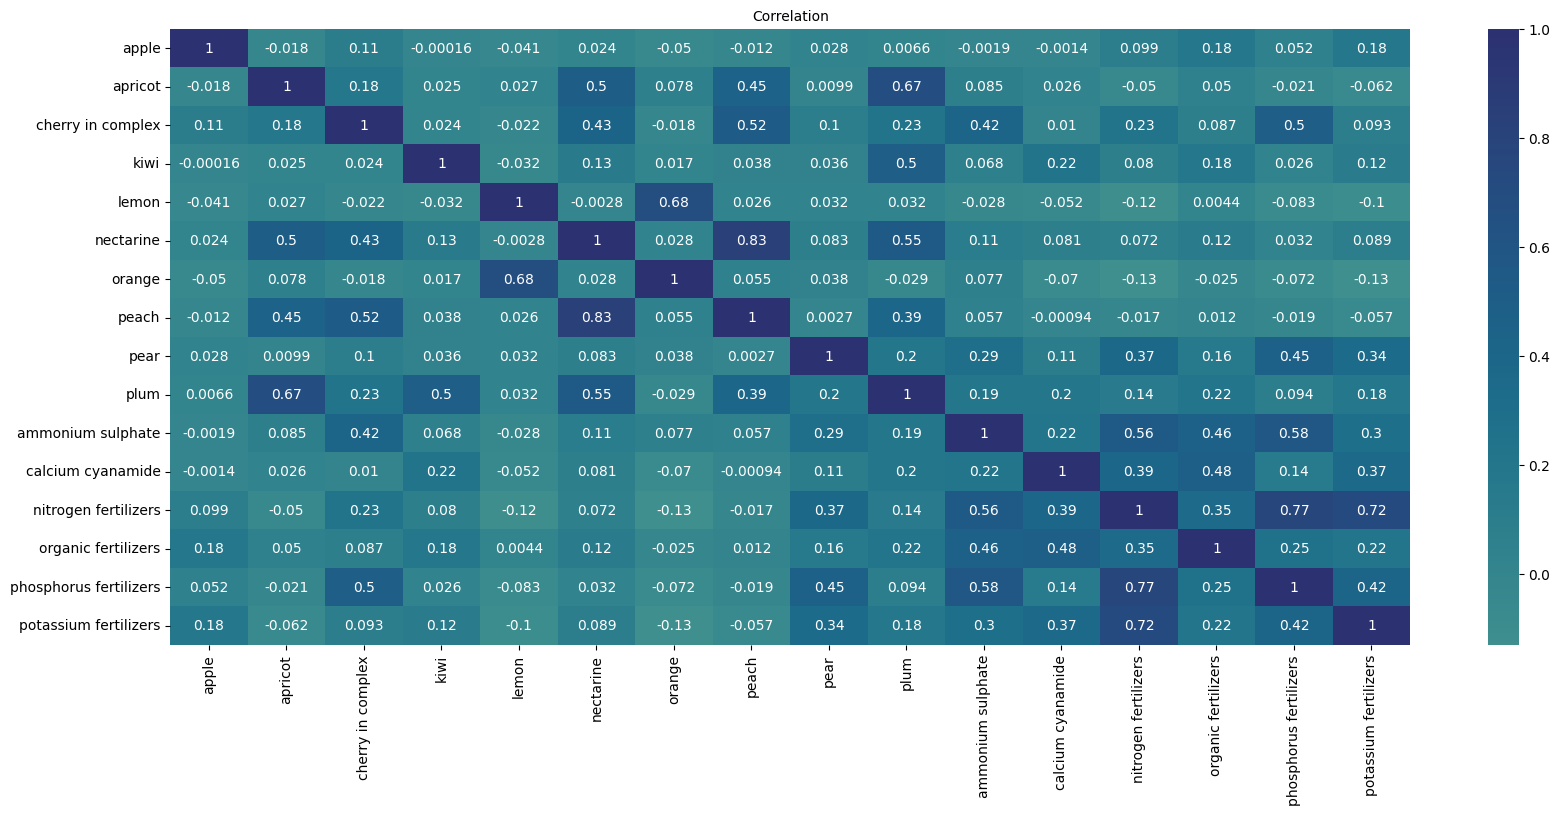

In [44]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of cereal production in Italy with high correlation with fertilizers: 

* Cherry has hight correlation phosphorus fertilizer, and correlation with ammonium sulphate fertilizer.

* Pear has correlation with phosphorus and potassium fertilizers.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html